<a href="https://colab.research.google.com/github/xslittlemaggie/Machine-Learning-Projects/blob/master/Diabetes_GBM_XGboost_lightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import library

In [0]:
import os
import pandas as pd
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot
import matplotlib.pyplot as plt

## Step 1: Load data from kaggle

In [0]:
os.environ['KAGGLE_USERNAME'] = "liulihuang" # username from the json file 
os.environ['KAGGLE_KEY'] = "7adfc6c4e6c5eec087031fbb7397aee5" # key from the json file (This key is incorrect5)

In [6]:
!pip install -q kaggle
#!kaggle datasets list -s diabetes  # It will list the 20 datasets including "diabetes" from kaggle
!kaggle datasets download -d uciml/pima-indians-diabetes-database -p /content/
!unzip -q /content/pima-indians-diabetes-database.zip -d /content/database/

ref                                           title                                                size  lastUpdated          downloadCount  
--------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
uciml/pima-indians-diabetes-database          Pima Indians Diabetes Database                        9KB  2016-10-06 18:31:56          62510  
brandao/diabetes                              Diabetes 130 US hospitals for years 1999-2008         4MB  2017-10-31 15:53:55           4486  
johndasilva/diabetes                          diabetes                                             12KB  2018-04-25 19:17:46           1873  
wanglaiqi/pimaindiansdiabetesdata             pima-indians-diabetes.data                            9KB  2017-10-12 07:49:20            950  
kandij/diabetes-dataset                       Diabetics prediction using logistic regression        9KB  2019-05-07 05:18:45            586  
codina

In [0]:
# need to upload data from local manually
data = pd.read_csv('/content/database/diabetes.csv')

In [13]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
data.shape

(768, 9)

In [0]:
X = data.iloc[:, 0:8]
Y = data.iloc[:,8]

In [17]:
print("The shape of x: {}".format(X.shape))
print("The shape of y: {}".format(Y.shape))   

The shape of x: (768, 8)
The shape of y: (768,)


## Step 2: Feature Creation

This section will include feature preprocessing, such as feature combinaiton, convertion, etc.

## Step 3: Training, testing datasets split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## Step 4: Modeling

### Model 1. GBM

In [19]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
  gb = GradientBoostingClassifier(n_estimators = 20, learning_rate = learning_rate, 
                                 max_features = 4, max_depth = 5, random_state = 0)
  gb.fit(x_train, y_train)
  print("Learning rate: ", learning_rate)
  print("Accuracy score (training): {:.3f}".format(gb.score(x_train, y_train)))
  print("Accuracy score (validation): {:.3f}".format(gb.score(x_test, y_test)))
  print()

Learning rate:  0.05
Accuracy score (training): 0.893
Accuracy score (validation): 0.792

Learning rate:  0.1
Accuracy score (training): 0.925
Accuracy score (validation): 0.799

Learning rate:  0.25
Accuracy score (training): 0.969
Accuracy score (validation): 0.786

Learning rate:  0.5
Accuracy score (training): 0.997
Accuracy score (validation): 0.792

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.773

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.792



In [20]:
# output confusion matrix and classification report of GBalgorithm on validation dataset
gb = GradientBoostingClassifier(n_estimators = 20, learning_rate = 0.5, 
                                 max_features = 4, max_depth = 5, random_state = 0)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred))
  

Confusion Matrix:
[[90 17]
 [15 32]]

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       107
           1       0.65      0.68      0.67        47

    accuracy                           0.79       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.79      0.79      0.79       154



In [21]:
# ROC curve and Area-under-curve(AUC)

y_scores_gb = gb.decision_function(x_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:.2f}".format(roc_auc_gb))

Area under ROC curve = 0.84


### Model 2: xgboost

In [22]:
#seed = 7
#test_size = 0.20

# split train, test datasets
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = seed)

# create model
model = XGBClassifier()
eval_set = [(x_test, y_test)]
# train the mdoel
model.fit(x_train, y_train, early_stopping_rounds = 10, 
          eval_metric = "auc",  # "logloss",
          eval_set = eval_set, 
          verbose = True)
# make predictions for the test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions 
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100.0))

[0]	validation_0-auc:0.818055
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.826705
[2]	validation_0-auc:0.828892
[3]	validation_0-auc:0.841718
[4]	validation_0-auc:0.836946
[5]	validation_0-auc:0.838636
[6]	validation_0-auc:0.837443
[7]	validation_0-auc:0.841718
[8]	validation_0-auc:0.846093
[9]	validation_0-auc:0.844601
[10]	validation_0-auc:0.840923
[11]	validation_0-auc:0.845695
[12]	validation_0-auc:0.847186
[13]	validation_0-auc:0.848578
[14]	validation_0-auc:0.849871
[15]	validation_0-auc:0.847584
[16]	validation_0-auc:0.850368
[17]	validation_0-auc:0.850567
[18]	validation_0-auc:0.848181
[19]	validation_0-auc:0.847584
[20]	validation_0-auc:0.846789
[21]	validation_0-auc:0.850467
[22]	validation_0-auc:0.851362
[23]	validation_0-auc:0.850766
[24]	validation_0-auc:0.85166
[25]	validation_0-auc:0.851064
[26]	validation_0-auc:0.85166
[27]	validation_0-auc:0.851064
[28]	validation_0-auc:0.851959
[29]	validation_0-auc:0.850368
[30]	validation_0-

## Step 3: Visualization of the feature importance

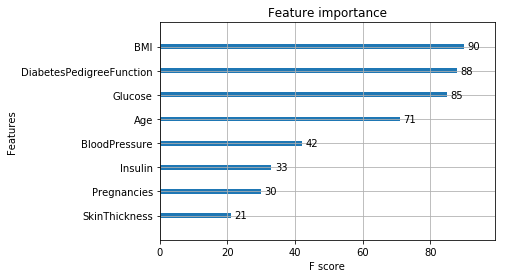

In [23]:
plot_importance(model)
pyplot.show()

## Step 4: More analysis about parameters

参数：
1. learning rate = 0.1
2. n_estimators = 1000
3. max_depth = 5
4. min_child_weight = 1
4. subsample = 0.8
5. objective = "binary: logistic"
6. nthread = 4
7. scale_pos_weight = 1
seed = 27

正则化参数
1. lambda
2. alpha

In [0]:
xgb1 = XGBClassifier(
learning_rate = 0.1, 
    n_estimators = 1000,
    max_depth = 5, 
    min_child_weight = 1,
    gamma = 0, 
    subsample = 0.8, # random sample 80%
    colsample_bytree = 0.8, 
    objective = "binary:logistic", # loss function
    nthread = 4, 
    scale_pos_weight = 1, # if the samples are unbananced, to make it be balanced
    seed = 27   
)

In [25]:
model = XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate = learning_rate)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)
grid_search = GridSearchCV(model, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
grid_result = grid_search.fit(X, Y)

# summarize results
print("Best performance: {:.4f} when {}".format(grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_["mean_test_score"]
params = grid_result.cv_results_["params"]
for mean, param in zip(means, params):
  print("Performance: {:.4f} when {}".format(mean, param))

Best performance: -0.4830 when {'learning_rate': 0.1}
Performance: -0.6897 when {'learning_rate': 0.0001}
Performance: -0.6613 when {'learning_rate': 0.001}
Performance: -0.5307 when {'learning_rate': 0.01}
Performance: -0.4830 when {'learning_rate': 0.1}
Performance: -0.5154 when {'learning_rate': 0.2}
Performance: -0.5573 when {'learning_rate': 0.3}


## Useful reference:
URL_1 = "https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d" **GBM**

URL_2 = "https://github.com/groverpr/Machine-Learning/blob/master/notebooks/01_Gradient_Boosting_Scratch.ipynb" **GBM code from scratch to complete**